In [29]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
import tqdm

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})



## Реализуем крестики-нолики

In [30]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [31]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -100, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [32]:
class Strategy:
    def __init__(self, env, name, isRandom=False):
        self.Q = {}
        self.env = env
        self.history = []
        self.isRandom = isRandom
        self.INITIAL_VALUE = 0.6
        self.eps = 0.1
        self.gamma = 0.99
        self.alpha = 0.1
        self.name = name
        return
    
    def get_Q(self, state):
        if state not in self.Q:
            actions = self.env.getEmptySpaces()
            self.Q[state] = [self.INITIAL_VALUE for i,a in enumerate(actions)]   
        
        return self.Q[state]

    def getActionGreedy(self, state):
        q_vals = self.get_Q(state)
        max_q = max(q_vals)
        action_id = random.choice([i for i,q in enumerate(q_vals) if q == max_q])
        self.history.append((state, action_id))
        return action_id
    
    def get_action_index(self, state, n):
        sample = np.random.random()
        if sample > self.eps:
            return self.getActionGreedy(state)
        return np.random.randint(n) 
    
    def reset(self):
        self.history = []
        
    def update(self, reward):
        self.history.reverse()
        first = True
        for h in self.history:
            s = h[0]
            a = h[1]
            if first:
                self.Q[s][a] = reward
                first = False
            else:
                self.Q[s][a] = self.Q[s][a] + self.alpha * (reward + self.gamma * maxQ - self.Q[s][a])
            
            maxQ = np.max(self.Q[s])
        

In [33]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
            else:
                ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s)
    
def get_move(env, pi, s, actions):
    '''Делаем ход'''
    if pi.isRandom:
        return np.random.randint(len(actions))
    else:
        return pi.get_action_index(s, len(actions))

In [34]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        print(f'move {a}')
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=True, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=True, fontq=fontq, fontx=fontx)

In [35]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
#plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

In [36]:
def play_game(env, pi1, pi2):
    done = False
    env.reset()
    reward = 0
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_move(env, pi1, s, actions)
        else:
            a = get_move(env, pi2, s, actions)
        observation, reward, done, info = env.step(actions[a])
    
    return observation, reward

def train(env, pi1, pi2, batch_size):
    pi1_wins = 0
    draws = 0
    pi2_wins = 0
    for i in range(batch_size):
    #for i in tqdm.tqdm(range(batch_size)):
        observation, reward = play_game(env, pi1, pi2)
        if reward == 1:
            pi1_wins += 1
        elif reward == -1:
            pi2_wins += 1
        else:
            draws += 1
            
        pi1.update(reward)
        pi2.update(-reward)
        pi1.reset()
        pi2.reset()
        #env.reset()
        
    return (pi1_wins, draws, pi2_wins)

def train_and_plot_games( pi1, pi2, episodes=500):
    x_wins = []
    draws = []
    y_wins = []
    count = []
    batch = 100
    for i in tqdm.tqdm(range (episodes)):
        res = train(env, pi1, pi2, batch)
        x_wins.append(res[0] / batch)
        draws.append(res[1] / batch)
        y_wins.append(res[2] / batch)
        count.append(batch * i)
        
    plt.ylabel('Доля событий')
    plt.xlabel('Число игр')
    plt.title(f'{pi1.name} vs {pi2.name}')

    plt.plot(count, x_wins, 'b-', label='Крестики выиграли')
    plt.plot(count, y_wins, 'r-', label='Нолики выиграли')
    plt.plot(count, draws, 'g-', label='Ничья')
    plt.legend(loc='best')
    plt.show()


In [9]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
Q_strtategy_x = Strategy(env, name='Q_strtategy_x', isRandom=False)
Random_y = Strategy(env, name='Random_y', isRandom=True)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.24it/s]


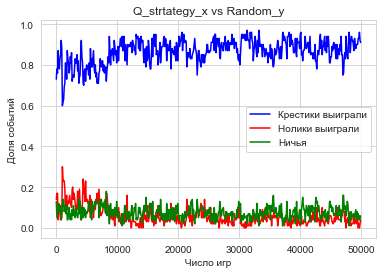

In [10]:
train_and_plot_games(Q_strtategy_x, Random_y, 500)

In [140]:
#plot_test_game(env, Q_strtategy_x, None, random_crosses=False, random_naughts=True, verbose=True, fontx=20)

In [11]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
Q_strtategy_x = Strategy(env, name='Q_strtategy_x', isRandom=False)
Q_strtategy_y = Strategy(env, name='Q_strtategy_y', isRandom=False)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:57<00:00,  8.67it/s]


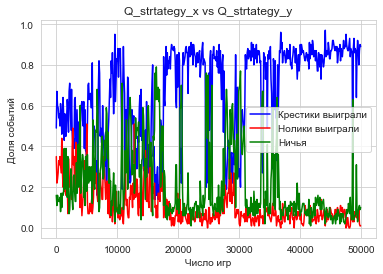

In [12]:
train_and_plot_games(Q_strtategy_x, Q_strtategy_y, 500)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:33<00:00,  5.33it/s]


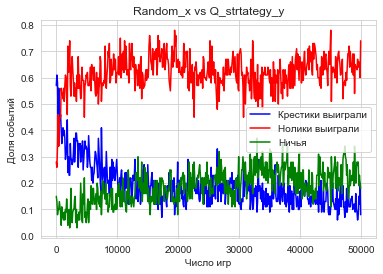

In [13]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
Random_x = Strategy(env, name='Random_x', isRandom=True)
Q_strtategy_y = Strategy(env, name='Q_strtategy_y', isRandom=False)
train_and_plot_games(Random_x, Q_strtategy_y, 500)

## Часть вторая: добавим нейронных сетей

In [42]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [43]:
class Network(nn.Module):
    def __init__(self, n=9, layer_size=36):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(n, layer_size)
        self.l2 = nn.Linear(layer_size, layer_size)
        self.output_layer = nn.Linear(layer_size, n)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

In [44]:
class TicTacToeDQN():
    def __init__(self, env, device=torch.device("cpu")):
        self.env = env
        self.model = Network(env.n_rows * env.n_cols)
        self.memory = ReplayMemory(50000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        self.device = device
        
        self.gamma = 0.8
        self.batch_size = 128
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 50000
        self.num_step = 0

    def select_greedy_action(self, state):
        with torch.no_grad():
            return self.model(state).data.max(1)[1].view(1, 1)
    
    def select_random_action(self, actions):
        n = len(actions)
        r = random.randrange(n)
        action_int = self.env.int_from_action(actions[r])
        with torch.no_grad():
            return torch.tensor([[action_int]], dtype=torch.int64, device=self.device)

    def select_action(self, state, actions):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state), False
        else:
            return self.select_random_action(actions), True
        
        
    def run_episode(self, do_learning=True, greedy=False):
        self.env.reset()
        n = self.env.n_cols * self.env.n_rows
        done = False
        reward_final = 0
        while not done:
            actions = self.env.getEmptySpaces()
            s = self.env.board.reshape(-1)
            state_tensor = torch.tensor([s], dtype=torch.float32, device=self.device)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action, isrand = self.select_action(state_tensor, actions)

            #print(state_tensor, action, isrand)
            observation, reward, done, _ = self.env.step(self.env.action_from_int(action.cpu().numpy()[0][0]))
            reward_final = reward
            # player 2
            if not done:
                actions = self.env.getEmptySpaces()
                a = self.select_random_action(actions)
                _, reward_final, done, _ = self.env.step(self.env.action_from_int(a.cpu().numpy()[0][0]))
                next_state = self.env.board.reshape(-1)
                next_state_tensor = torch.tensor([next_state], dtype=torch.float32, device=self.device)
            if done:
                next_state_tensor = None

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32, device=self.device))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state
        return reward_final

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        #batch_next_state = Variable(torch.cat(batch_next_state))
        
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch_next_state)),
            device=self.device,
            dtype=torch.bool,
        )
        non_final_next_states = torch.cat([s for s in batch_next_state if s is not None])
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        next_state_values[non_final_mask] = self.model(non_final_next_states).detach().max(1)[0]
         
        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        #Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qmax = next_state_values
        
        Qnext = batch_reward + (self.gamma * Qmax)
        Qnext = (next_state_values * self.gamma) + batch_reward

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def fit(self, n_steps):
        
        x_wins = 0
        draws = 0
        y_wins = 0 
        illegal = 0
        for step in range(n_steps):
            reward = self.run_episode()
            if reward == 1:
                x_wins += 1
            elif reward == -1:
                y_wins += 1
            elif reward == 0:
                draws += 1
            else:
                illegal += 1
                
        return (x_wins, draws, y_wins, illegal)
            
    def train_and_plot_games(self, episodes=500):
        x_wins = []
        draws = []
        y_wins = []
        illegal = []
        count = []
        n_steps = 100
        for i in tqdm.tqdm(range (episodes)):
            res = self.fit(n_steps)
            x_wins.append(res[0] / n_steps)
            draws.append(res[1] / n_steps)
            y_wins.append(res[2] / n_steps)
            illegal.append(res[3] / n_steps)
            count.append(n_steps * i)

        plt.ylabel('Доля событий')
        plt.xlabel('Число игр')

        plt.plot(count, x_wins, 'b-', label='Крестики выиграли')
        plt.plot(count, y_wins, 'r-', label='Нолики выиграли')
        plt.plot(count, draws, 'g-', label='Ничья')
        plt.plot(count, illegal, 'p-', label='Неверный ход')
        plt.legend(loc='best')
        plt.show()

23:28:27.183238	Starting training ...





  0%|                                                                                          | 0/500 [00:00<?, ?it/s]


  0%|▏                                                                                 | 1/500 [00:00<07:49,  1.06it/s]


  0%|▎                                                                                 | 2/500 [00:06<19:46,  2.38s/it]


  1%|▍                                                                                 | 3/500 [00:11<26:25,  3.19s/it]


  1%|▋                                                                                 | 4/500 [00:16<30:52,  3.74s/it]


  1%|▊                                                                                 | 5/500 [00:22<34:35,  4.19s/it]


  1%|▉                                                                                 | 6/500 [00:26<35:24,  4.30s/it]


  1%|█▏                                                                                | 7/500 [00:31<35:40,  4.34s/it]


  2%|█▎              

 27%|█████████████████████▍                                                          | 134/500 [09:46<24:56,  4.09s/it]


 27%|█████████████████████▌                                                          | 135/500 [09:50<24:54,  4.10s/it]


 27%|█████████████████████▊                                                          | 136/500 [09:54<25:31,  4.21s/it]


 27%|█████████████████████▉                                                          | 137/500 [09:59<25:44,  4.26s/it]


 28%|██████████████████████                                                          | 138/500 [10:03<25:34,  4.24s/it]


 28%|██████████████████████▏                                                         | 139/500 [10:07<25:05,  4.17s/it]


 28%|██████████████████████▍                                                         | 140/500 [10:11<24:55,  4.15s/it]


 28%|██████████████████████▌                                                         | 141/500 [10:15<24:36,  4.11s/it]


 28%|███████████████████

 54%|██████████████████████████████████████████▉                                     | 268/500 [18:34<14:38,  3.79s/it]


 54%|███████████████████████████████████████████                                     | 269/500 [18:38<14:41,  3.82s/it]


 54%|███████████████████████████████████████████▏                                    | 270/500 [18:41<14:35,  3.81s/it]


 54%|███████████████████████████████████████████▎                                    | 271/500 [18:45<14:30,  3.80s/it]


 54%|███████████████████████████████████████████▌                                    | 272/500 [18:49<14:09,  3.72s/it]


 55%|███████████████████████████████████████████▋                                    | 273/500 [18:52<13:59,  3.70s/it]


 55%|███████████████████████████████████████████▊                                    | 274/500 [18:56<13:59,  3.72s/it]


 55%|████████████████████████████████████████████                                    | 275/500 [19:00<13:49,  3.69s/it]


 55%|███████████████████

 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [27:16<06:23,  3.91s/it]


 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [27:20<06:24,  3.97s/it]


 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [27:24<06:14,  3.90s/it]


 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [27:28<06:05,  3.85s/it]


 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [27:31<05:56,  3.79s/it]


 81%|█████████████████████████████████████████████████████████████████               | 407/500 [27:35<05:56,  3.84s/it]


 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [27:39<05:57,  3.89s/it]


 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [27:43<05:50,  3.85s/it]


 82%|███████████████████

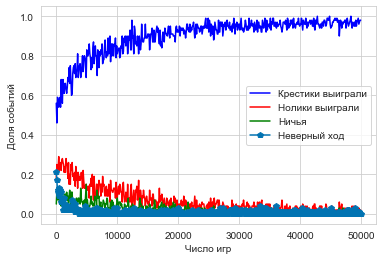

00:02:06.411461		...done!


In [138]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn = TicTacToeDQN(env)#, device)

print("%s\tStarting training ..." % (datetime.now().time()))
dqn.train_and_plot_games(500)
print("%s\t\t...done!" % (datetime.now().time()))



In [ ]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
dqn = TicTacToeDQN(env)

print("%s\tStarting training ..." % (datetime.now().time()))
dqn.train_and_plot_games(300)
print("%s\t\t...done!" % (datetime.now().time()))

## Часть третья: расширим и углубим поиск --> в другом блокноте